Shakespeare's plays are traditionally classified into Comedies and Tragedies. The goal of this document is to use Natural Language Processing to classify the plays into 2 groups and compare the results to the traditional classification.

#### Required libraries

In [1]:
import nltk
import math
import re
import lda
import sklearn
import my_kmeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from ggplot import *

In [2]:
stopwords = nltk.corpus.stopwords.words('english')

#### Input Data

shakespeare.txt includes all Shakespeare's plays and poems. Each line of the file starts with the expression title@row_number:

>hamlet@56053	HAMLET	Words, words, words.
>
>hamlet@56081
>
>hamlet@56082	LORD POLONIUS	What is the matter, my lord?
>
>hamlet@56125
>
>hamlet@56126	HAMLET	Between who?
>
>hamlet@56146
>
>hamlet@56147	LORD POLONIUS	I mean, the matter that you read, my lord.

### Text normalization

- find all the titles as a unique list of title@ expressions and delete the histories (for now) and the poems
- split the text into a list of lines
- for each play create an element in _collection_, delete title@row_number and store as plain text

In [3]:
collection = {} # dictionary of raw texts

with open('../../Datastore/shakespeare.txt', 'r') as f:
	raw = f.read()
	titles = [t for t in set(re.findall(r'[a-z]+@{1}', raw))]

	histories = ['glossary@', 'various@', 'sonnets@', 'kinghenryvi@', 'kinghenryiv@', 
                 'venusandadonis@', 'rapeoflucrece@', 'loverscomplaint@', 'kingrichardiii@', 
                 'kingrichardii@', 'kingjohn@', 'kinghenryv@','kinghenryviii@']
	titles = [title for title in titles if title not in histories]

	lines = raw.splitlines()
	for t in titles:
		key = t[:-1]
		text = [re.sub(r'[a-z]+@{1}[0-9]+[ \t\n]+','', l) for l in lines if re.match(t+'[0-9]+', l)]
		collection[key] = ' '.join(text)

- Initialize the tokenizer (disregards punctuation signs) and a stemmer (Porter algorithm)

In [4]:
tokenizer = RegexpTokenizer(r'\w+')
st = nltk.stem.PorterStemmer()

Add glossary of victorian english words

In [5]:
with open('glossary.txt', 'r') as f:
	glossary = f.read()

glossary = tokenizer.tokenize(glossary)

In [6]:
tokens = {}
stemmed = {}
documents = {} # dictionary of normalized texts

for key in collection.keys():
	collection[key] = re.sub(r'\n?\n[A-Z]*\t|\n|\t', ' ', collection[key])
	tokens[key] = tokenizer.tokenize(collection[key]) # delete punctuation
	names = [w.lower() for w in set(tokens[key]) if w.isupper()]
	tokens[key] = [w for w in tokens[key] if w.lower() not in names]
	tokens[key] = [w.lower() for w in tokens[key] if w.lower() not in stopwords + glossary]
	stemmed[key] = [st.stem(w.lower()) for w in tokens[key]]
	documents[key] = ' '.join(stemmed[key])    

**Feature Extraction/Vectorization**: given a Vocabulary (list of unique words in the corpus) each play is represented as an array of frequencies

In [7]:
vectorizer = CountVectorizer()

In [8]:
tfidfTransf = TfidfTransformer()

CountVectorizer() requires as input a list of documents (raw text)

In [9]:
freq_matrix = vectorizer.fit_transform(list(documents.values())).toarray()
freq_matrix.shape

(27, 11959)

In [10]:
tfidf_matrix = tfidfTransf.fit_transform(freq_matrix)
tfidf_matrix.shape

(27, 11959)

### Latent Dirichlet Allocation

In natural language processing, latent Dirichlet allocation (LDA) is a generative model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's creation is attributable to one of the document's topics.

In [11]:
titles = np.array(documents.keys())
labels = np.array(['tragedy','comedy','comedy', 'tragedy','tragedy','tragedy','tragedy', 
                           'tragedy','comedy','comedy','comedy', 'comedy','tragedy','comedy', 
                           'tragedy', 'comedy', 'comedy','comedy', 'comedy', 'comedy','comedy', 
                           'comedy', 'tragedy', 'tragedy', 'comedy','comedy','comedy'])
year = np.array([1591, 1604, 1601, 1606, 1599, 1606, 1605, 1599, 1610, 1596, 1594, 1609, 
                 1605, 1598, 1607, 1600, 1603, 1610, 1590, 1599, 1600, 1595, 1604, 1592, 
                 1594, 1589, 1607])


In [12]:
lookup = []
for index in xrange(len(titles)):
    lookup.append( (titles[index], labels[index], year[index]))

lookup = np.array(lookup)
unique_words = vectorizer.get_feature_names()

Number of topics the dumb way: max likelihood

In [13]:
loglikelihoods = []
for k in range(2, 28):
    topic_model = lda.LDA(n_topics = k, n_iter = 500)
    topic_model.fit(freq_matrix)
    loglikelihoods.append(topic_model.loglikelihood())

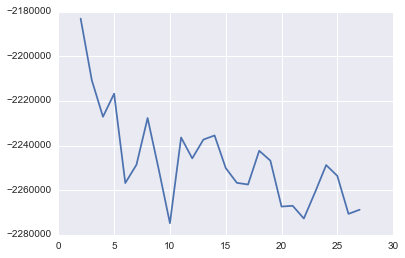

In [14]:
%matplotlib inline
plt.plot(range(2,28), loglikelihoods)
plt.show()

In [15]:
num_of_topics = 8
topic_model = lda.LDA(n_topics= num_of_topics, n_iter=2000)
topic_model.fit(freq_matrix)

<lda.lda.LDA instance at 0x101de5b00>

In [16]:
topic_model.loglikelihood()

-2217150.5856773523

In [17]:
topic_word = topic_model.topic_word_

n_top_words = 15

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(unique_words)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: sweet lord ladi fair wit eye god day great fool cousin princ prais grace
Topic 1: lord first fool clown gentleman ladi second servant daughter honour father like god madam
Topic 2: sir ti upon heaven know brother life put speak natur think great honour strang
Topic 3: master husband hous wife pray go host woman well money signior jew home kate
Topic 4: king son eye sleep hand play murder dead tear death father moon like lie
Topic 5: rome first nobl citizen senat us soldier second lord enter war roman god peopl
Topic 6: sir hast us day gone master time hous therefor present mine enter welcom stay
Topic 7: come shall good love let would well man say make go enter one know


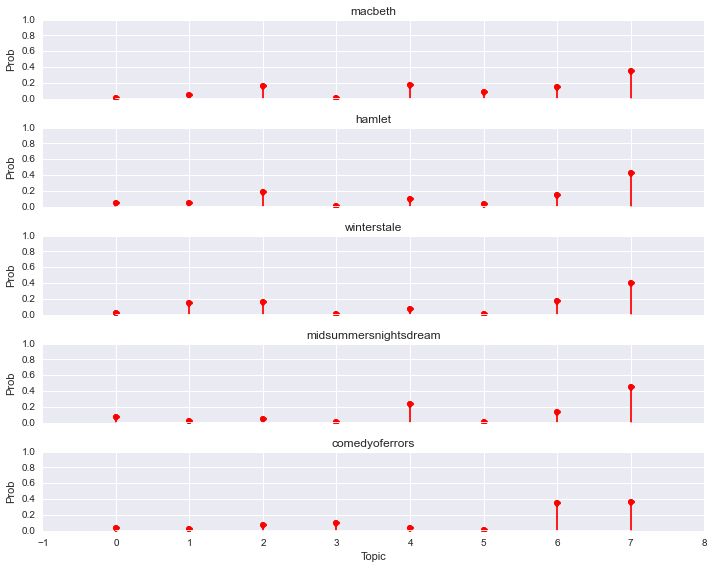

In [18]:
%matplotlib inline

doc_topic = topic_model.doc_topic_

f, ax= plt.subplots(5, 1, figsize=(10, 8), sharex=True)
for i, k in enumerate([3, 4, 11, 21, 24]):
    ax[i].stem(doc_topic[k,:], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[i].set_xlim(-1, num_of_topics)
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title(titles[k])

ax[4].set_xlabel("Topic")

plt.tight_layout()
plt.show()

### K-Means

In [19]:
km_topics = KMeans(n_clusters = 2, init = 'random', random_state = 15)
km_topics.fit(doc_topic)

KMeans(copy_x=True, init='random', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=15, tol=0.0001,
    verbose=0)

In [20]:
km_topics.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0], dtype=int32)

In [21]:
lookup[ km_topics.labels_ == 0]

array([['titusandronicus', 'tragedy', '1591'],
       ['allswellthatendswell', 'comedy', '1604'],
       ['macbeth', 'tragedy', '1606'],
       ['hamlet', 'tragedy', '1599'],
       ['antonyandcleopatra', 'tragedy', '1606'],
       ['kinglear', 'tragedy', '1605'],
       ['juliuscaesar', 'tragedy', '1599'],
       ['tempest', 'comedy', '1610'],
       ['winterstale', 'comedy', '1609'],
       ['timonofathens', 'tragedy', '1605'],
       ['coriolanus', 'tragedy', '1607'],
       ['measureforemeasure', 'comedy', '1603'],
       ['cymbeline', 'comedy', '1610'],
       ['othello', 'tragedy', '1604'],
       ['periclesprinceoftyre', 'comedy', '1607']], 
      dtype='|S21')

In [22]:
lookup[km_topics.labels_ == 1]

array([['twelfthnight', 'comedy', '1601'],
       ['merchantofvenice', 'comedy', '1596'],
       ['loveslabourslost', 'comedy', '1594'],
       ['muchadoaboutnothing', 'comedy', '1598'],
       ['troilusandcressida', 'comedy', '1600'],
       ['tamingoftheshrew', 'comedy', '1590'],
       ['asyoulikeit', 'comedy', '1599'],
       ['merrywivesofwindsor', 'comedy', '1600'],
       ['midsummersnightsdream', 'comedy', '1595'],
       ['romeoandjuliet', 'tragedy', '1592'],
       ['comedyoferrors', 'comedy', '1594'],
       ['twogentlemenofverona', 'comedy', '1589']], 
      dtype='|S21')

In [23]:
lookup_df = pd.DataFrame({'title':titles, 'label':labels, 'year':year, 'cluster':km_topics.labels_})
groups = set(km_topics.labels_)

In [24]:
%load_ext rmagic

/Library/Python/2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


In [25]:
%Rpush lookup_df
%R boxplot(lookup_df$year ~ lookup_df$cluster, col = c('darkorchid4', 'darkorange')); abline(h = 1603, lty = 2)

ERROR: Line magic function `%Rpush` not found.
ERROR: Line magic function `%R` not found.


In [26]:
%R plot(x = titles$year, y = rep(1, nrow(titles)), pch = "*", cex = 3, col = ifelse(titles$cluster == 1, "darkorange", "darkorchid4"), xlab = "Year", ylab = "", yaxt = "n")

ERROR: Line magic function `%R` not found.


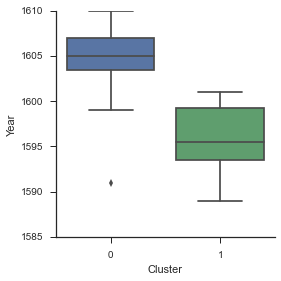

In [27]:
sns.set(style="ticks")

g = sns.factorplot(x = 'cluster', y = 'year', data = lookup_df, kind='box')
g.despine()
g.set_axis_labels('Cluster', 'Year')

#### My own implementation of k-means

In [28]:
my_km_topics = my_kmeans.km(dat = doc_topic, k = 2, random_state = 8)

iteration 1
iteration 2


In [29]:
lookup[my_km_topics == 0]

array([['titusandronicus', 'tragedy', '1591'],
       ['allswellthatendswell', 'comedy', '1604'],
       ['macbeth', 'tragedy', '1606'],
       ['hamlet', 'tragedy', '1599'],
       ['antonyandcleopatra', 'tragedy', '1606'],
       ['kinglear', 'tragedy', '1605'],
       ['juliuscaesar', 'tragedy', '1599'],
       ['tempest', 'comedy', '1610'],
       ['winterstale', 'comedy', '1609'],
       ['timonofathens', 'tragedy', '1605'],
       ['coriolanus', 'tragedy', '1607'],
       ['measureforemeasure', 'comedy', '1603'],
       ['cymbeline', 'comedy', '1610'],
       ['othello', 'tragedy', '1604'],
       ['periclesprinceoftyre', 'comedy', '1607']], 
      dtype='|S21')

In [30]:
lookup[my_km_topics == 1]

array([['twelfthnight', 'comedy', '1601'],
       ['merchantofvenice', 'comedy', '1596'],
       ['loveslabourslost', 'comedy', '1594'],
       ['muchadoaboutnothing', 'comedy', '1598'],
       ['troilusandcressida', 'comedy', '1600'],
       ['tamingoftheshrew', 'comedy', '1590'],
       ['asyoulikeit', 'comedy', '1599'],
       ['merrywivesofwindsor', 'comedy', '1600'],
       ['midsummersnightsdream', 'comedy', '1595'],
       ['romeoandjuliet', 'tragedy', '1592'],
       ['comedyoferrors', 'comedy', '1594'],
       ['twogentlemenofverona', 'comedy', '1589']], 
      dtype='|S21')